# Homework 5

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Problem 1

**Problem statement:** Take the Gaia XP data given to you by Jiadong Li. It consists of a set of ESA Gaia Mission BP/RP spectral coefficients, and a set of labels from SDSS-IV APOGEE. These are real data, people, and a real problem. Use linear regression to learn a function that takes as input the BP and RP spectral coefficients and delivers as output the label TEFF, which is the effective temperature of the stars. Instead of using the BP/RP coefficients right out of the box, consider dividing all BP & RP coefficients by the first (zeroth) component of the RP coefficients. Don’t forget to include the number 1 as a regressor (the constant term). Train on the training set and use the validation set to assess your accuracy (RMS maybe or median absolute deviation). Ask questions of Hogg and Jiadong, who know these data well!

In [2]:
# Load the data
with open('hw5_train.pkl', 'rb') as f:
    data_tr = pickle.load(f)
    
with open('hw5_val.pkl', 'rb') as f:
    data_va = pickle.load(f)

print("Training data:")
print("\n".join([f"  '{k}': {data_tr[k].shape}" for k in data_tr]))

print("Validation data:")
print("\n".join([f"  '{k}': {data_va[k].shape}" for k in data_va]))

Training data:
  'bp_coef': (4000, 55)
  'rp_coef': (4000, 55)
  'labels': (4000, 2)
Validation data:
  'bp_coef': (1000, 55)
  'rp_coef': (1000, 55)
  'labels': (1000, 2)


In [3]:
# Normalize the data
def normalize(data):
    rp, bp, teff = data['rp_coef'], data['bp_coef'], data['labels'][:, 0]
    rp /= rp[:, :1]
    bp /= rp[:, :1]
    
    X = np.concatenate((rp, bp), axis=1)
    y = teff
    return X, y

X_tr, y_tr = normalize(data_tr)
X_va, y_va = normalize(data_va)

print('Data shapes:')
print(f'  X_tr: {X_tr.shape}')
print(f'  y_tr: {y_tr.shape}')
print(f'  X_va: {X_va.shape}')
print(f'  y_va: {y_va.shape}')

Data shapes:
  X_tr: (4000, 110)
  y_tr: (4000,)
  X_va: (1000, 110)
  y_va: (1000,)


In [4]:
# Perform linear regression and assess on training and validation sets
result = np.linalg.lstsq(X_tr, y_tr, rcond=None)
theta_hat = result[0]
print(f'Parameter shape: {theta_hat.shape}')

def assess(theta, X, y, title='Assessment scores:'):
    pred = X @ theta
    mse = np.mean(np.square(y - pred))
    rms = np.sqrt(mse)
    mad = np.mean(np.abs(y - pred))
    print()
    print(title)
    print(f'  MSE:        {mse:.3e}')
    print(f'  RMS:        {rms:.3e}')
    print(f'  Scaled RMS: {rms / np.mean(y):.3e}')
    print(f'  MAD:        {mad:.3e}')
    print(f'  Scaled MAD: {mad / np.mean(y):.3e}')

assess(theta_hat, X_tr, y_tr, title='Scores (train):')
assess(theta_hat, X_tr, y_tr, title='Scores (validation):')

Parameter shape: (110,)

Scores (train):
  MSE:        2.213e+04
  RMS:        1.488e+02
  Scaled RMS: 3.283e-02
  MAD:        1.061e+02
  Scaled MAD: 2.342e-02

Scores (validation):
  MSE:        2.213e+04
  RMS:        1.488e+02
  Scaled RMS: 3.283e-02
  MAD:        1.061e+02
  Scaled MAD: 2.342e-02


This performance isn't bad! The raw values are somewhat large, but when we scale by the average value of the lables (and therefore compute a fractional average error), we see that our results are decent. In particular, the scaled RMS and MAD values show that on both the train and validation sets, our predictions are (on average) accurate to a few percent.

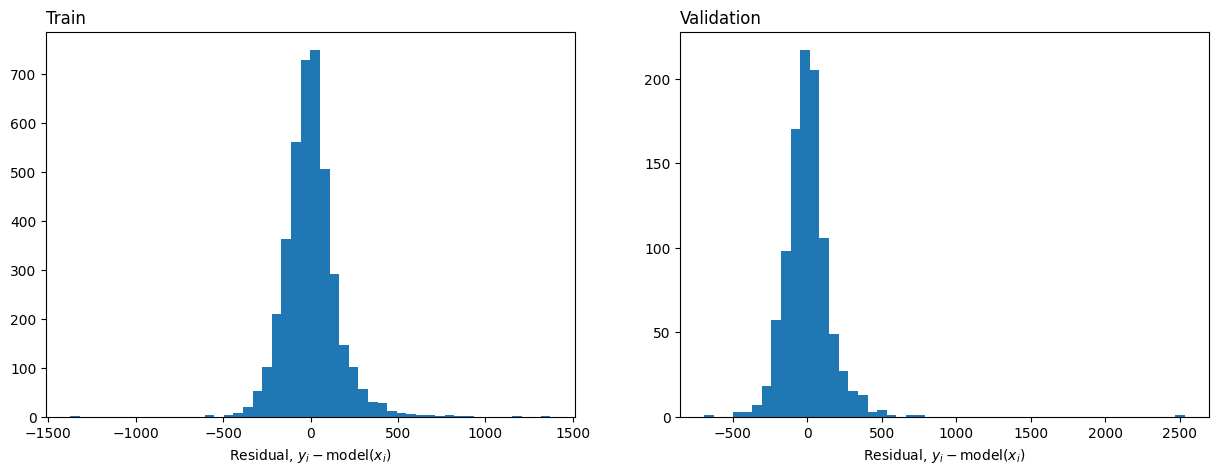

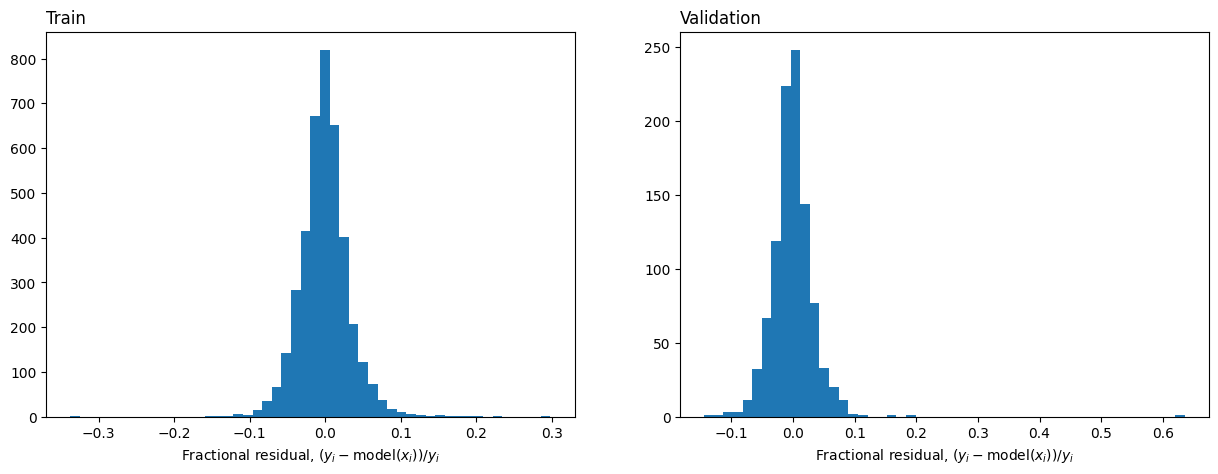

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].hist( y_tr - X_tr @ theta_hat, bins=50 )
axs[0].set_xlabel('Residual, $y_i - \\mathrm{model}(x_i)$')
axs[0].set_title('Train', loc='left')
axs[1].hist( y_va - X_va @ theta_hat, bins=50 )
axs[1].set_xlabel('Residual, $y_i - \\mathrm{model}(x_i)$')
axs[1].set_title('Validation', loc='left')
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].hist( (y_tr - X_tr @ theta_hat) / y_tr, bins=50 )
axs[0].set_xlabel('Fractional residual, $(y_i - \\mathrm{model}(x_i)) / y_i$')
axs[0].set_title('Train', loc='left')
axs[1].hist( (y_va - X_va @ theta_hat) / y_va, bins=50 )
axs[1].set_xlabel('Fractional residual, $(y_i - \\mathrm{model}(x_i)) / y_i$')
axs[1].set_title('Validation', loc='left')
plt.show()

# Problem 2

**Problem statement:** Now consider only the RP spectral coefficients. Make a linear model to predict TEFF. Then make all quadratic combinations of the RP coefficients and make a linear model of the linear and quadratic combinations to predict TEFF. Can you afford to do cubic too? Once again, divide the coefficients by RP[0] to start. Once again, don’t forget to include the constant term. Train on the training set and use the validation set to assess your accuracy.

In [6]:
# Re-do normalization using only RP
def normalize(data):
    rp, teff = data['rp_coef'],data['labels'][:, 0]
    rp /= rp[:, :1]
    return rp, teff

X_tr, y_tr = normalize(data_tr)
X_va, y_va = normalize(data_va)

print('Data shapes:')
print(f'  X_tr: {X_tr.shape}')
print(f'  y_tr: {y_tr.shape}')
print(f'  X_va: {X_va.shape}')
print(f'  y_va: {y_va.shape}')

Data shapes:
  X_tr: (4000, 55)
  y_tr: (4000,)
  X_va: (1000, 55)
  y_va: (1000,)


In [15]:
# Linear model:
result = np.linalg.lstsq(X_tr, y_tr, rcond=None)
theta_hat = result[0]
print(f'Parameter shape: {theta_hat.shape}')

def assess(theta, X, y, title='Assessment scores:'):
    pred = X @ theta
    mse = np.mean(np.square(y - pred))
    rms = np.sqrt(mse)
    mad = np.mean(np.abs(y - pred))
    print()
    print(title)
    print(f'  MSE:        {mse:.3e}')
    print(f'  RMS:        {rms:.3e}')
    print(f'  Scaled RMS: {rms / np.mean(y):.3e}')
    print(f'  MAD:        {mad:.3e}')
    print(f'  Scaled MAD: {mad / np.mean(y):.3e}')

assess(theta_hat, X_tr, y_tr, title='Scores (train):')
assess(theta_hat, X_va, y_va, title='Scores (validation):')

Parameter shape: (55,)

Scores (train):
  MSE:        2.926e+04
  RMS:        1.710e+02
  Scaled RMS: 3.775e-02
  MAD:        1.219e+02
  Scaled MAD: 2.691e-02

Scores (validation):
  MSE:        3.960e+04
  RMS:        1.990e+02
  Scaled RMS: 4.398e-02
  MAD:        1.218e+02
  Scaled MAD: 2.691e-02


For a general quadratic model, we'll consider all combinations of two RP spectral coefficients. There are 55 RP coefficients, so we have each of these squared (55 combinations) as well as the 55-choose-2 products of two non-equal coefficients. 55-choose-2 is 1485, meaning we have a total of 1540 new terms in our model, making 1595 in total.

In [13]:
# Quadratic model
def quadratic_X(X):
    from scipy.special import binom
    
    n_quad = int(binom(X.shape[1], 2)) + X.shape[1]
    X_quad = np.zeros(( X.shape[0], n_quad ))
    
    index = 0
    for i1 in range(X.shape[1]):
        for i2 in range(i1, X.shape[1]):
            X_quad[:, index] = X[:, i1] * X[:, i2]
            index += 1
            
    return np.concatenate((X, X_quad), axis=1)

X_quad_tr = quadratic_X(X_tr)
X_quad_va = quadratic_X(X_va)

print('Data shapes:')
print(f'  X_tr: {X_quad_tr.shape}')
print(f'  y_tr: {y_tr.shape}')
print(f'  X_va: {X_quad_va.shape}')
print(f'  y_va: {y_va.shape}')

# Fit the model
result = np.linalg.lstsq(X_quad_tr, y_tr, rcond=None)
theta_hat = result[0]
print(f'Parameter shape: {theta_hat.shape}')

# Assess
assess(theta_hat, X_quad_tr, y_tr, title='Scores (train, quadratic):')
assess(theta_hat, X_quad_va, y_va, title='Scores (validation, quadratic):')

Data shapes:
  X_tr: (4000, 1595)
  y_tr: (4000,)
  X_va: (1000, 1595)
  y_va: (1000,)
Parameter shape: (1595,)

Scores (train, quadratic):
  MSE:        4.826e+03
  RMS:        6.947e+01
  Scaled RMS: 1.533e-02
  MAD:        5.207e+01
  Scaled MAD: 1.149e-02

Scores (validation, quadratic):
  MSE:        4.603e+06
  RMS:        2.145e+03
  Scaled RMS: 4.742e-01
  MAD:        2.295e+02
  Scaled MAD: 5.072e-02


To do a general cubic model, we'll have the following makeup of cubic terms:
- 55 perfect cubes (e.g. $\text{RP}_i^3$)
- (55 choose 3) combinations of three unique coefficients
- (55 choose 2) * 2 combinations of two unique coefficients, since there are (55 choose 2) ways to combine two unique coefficients and then 2 choices for which of the two coefficients to square

This totals 29,260 additional features; 30,855 features in total.

In [14]:
# Cubic model
def cubic_X(X):
    from scipy.special import binom
    
    X_quad = quadratic_X(X)[:, (X.shape[1]):]
    
    n_cubic = int(binom(X.shape[1], 3)) + 2 * int(binom(X.shape[1], 2)) + X.shape[1]
    X_cubic = np.zeros(( X.shape[0], n_cubic ))
    
    index = 0
    for i1 in range(X.shape[1]):
        for i2 in range(i1, X.shape[1]):
            for i3 in range(i2, X.shape[1]):
                X_cubic[:, index] = X[:, i1] * X[:, i2] * X[:, i3]
                index += 1
            
    return np.concatenate((X, X_quad, X_cubic), axis=1)

X_cubic_tr = cubic_X(X_tr)
X_cubic_va = cubic_X(X_va)

print('Data shapes:')
print(f'  X_tr: {X_cubic_tr.shape}')
print(f'  y_tr: {y_tr.shape}')
print(f'  X_va: {X_cubic_va.shape}')
print(f'  y_va: {y_va.shape}')

# Fit the model
result = np.linalg.lstsq(X_cubic_tr, y_tr, rcond=None)
theta_hat = result[0]
print(f'Parameter shape: {theta_hat.shape}')

# Assess
assess(theta_hat, X_cubic_tr, y_tr, title='Scores (train, cubic):')
assess(theta_hat, X_cubic_va, y_va, title='Scores (validation, cubic):')

Data shapes:
  X_tr: (4000, 30855)
  y_tr: (4000,)
  X_va: (1000, 30855)
  y_va: (1000,)
Parameter shape: (30855,)

Scores (train, cubic):
  MSE:        7.325e-01
  RMS:        8.559e-01
  Scaled RMS: 1.889e-04
  MAD:        3.009e-01
  Scaled MAD: 6.641e-05

Scores (validation, cubic):
  MSE:        1.366e+11
  RMS:        3.696e+05
  Scaled RMS: 8.168e+01
  MAD:        1.464e+04
  Scaled MAD: 3.236e+00


Let's summarize the scores of the scaled methods in a table.

| Method | RMS (tr.) | MAD (tr.) | RMS (val.) | MAD (val.) |
| --- | --- | --- | --- | --- |
| Linear | 0.03775 | 0.02691 | 0.04398 | 0.02691 |
| Quadratic | 0.01533 | 0.01149 | 0.4742 | 0.05072 |
| Cubic | 0.00019 | 0.00007 | 8.168 | 3.236 |

Increasing the order of the model appears to decrease its training errors considerably. However, it also appears to increase the resulting validation errors, indicating that higher order methods are _overfitting_. It should also be noted that the training and validation scores for the linear method are basically the same as each other, which is an indicator that the linear method generalizes well.

# Problem 3

**Problem statement:** Fit the famous data set 11 from Problem Set 2, but now with a single Gaussian Process. Choose as your kernel the Matern 3/2 kernel. Use the form of the GP regression shown in class, that involves both the kernel matrix K and the noise covariance C. Plot the GP result by evaluating the GP on a set of test locations which is a fine grid of spacing (say) 0.1 days over a footprint that goes from -50 days to 1075 days (ie, more than the span of the data). Plot the GP result for three different (but all reasonable) values for the Matern kernel width (the hyper-parameter). Bonus points: Plot not just the best-fit, but the uncertainty (variance) region around that fit, as per Rasmussen & Williams.

In [ ]:
# Load the Problem set 2 data
with open("hw2_data.pkl", "rb") as f:
    data = pickle.load(f).T

t_i = data[0]
sigma_i = data[1]
y_i = data[-1]

data = (t_i, y_i, sigma_i)  # the last dataset only